In [2]:
# Import pymongo stuff
import pymongo
import pprint
import json
import warnings
import pandas as pd 
from bson import ObjectId
warnings.filterwarnings('ignore')

myclient = pymongo.MongoClient('mongodb://localhost:27017')
db = myclient["oceanbears"] 

## MongoDB Queries
### Query 1: Revenue Analysis
Revenue earned by each shop with rental and purchase of each of the items (surfboard, gear, wetsuit, paddle and other items) and revenue forecasting.

First we study the revenue by month, year, shop and type of item:

In [28]:
aggregation = [
    {
        '$addFields': {
            'month': {
                '$month': '$datetime_out'
            }, 
            'year': {
                '$year': '$datetime_out'
            }
        }
    }, {
        '$lookup': {
            'from': 'inventory', 
            'localField': 'IID', 
            'foreignField': '_id', 
            'as': 'inventory'
        }
    }, {
        '$unwind': {
            'path': '$inventory', 
            'preserveNullAndEmptyArrays': False
        }
    }, {
        '$lookup': {
            'from': 'shops', 
            'localField': 'inventory.owned_by_shop', 
            'foreignField': '_id', 
            'as': 'shop'
        }
    }, {
        '$unwind': {
            'path': '$shop', 
            'preserveNullAndEmptyArrays': False
        }
    }, {
        '$lookup': {
            'from': 'items', 
            'localField': 'inventory.item_id', 
            'foreignField': '_id', 
            'as': 'item'
        }
    }, {
        '$unwind': {
            'path': '$item', 
            'preserveNullAndEmptyArrays': False
        }
    }, {
        '$group': {
            '_id': {
                'month': '$month', 
                'year': '$year', 
                'item': '$item._id'
            }, 
            'revenue': {
                '$sum': '$total_price'
            }, 
            'item': {
                '$first': '$item'
            }, 
            'shop': {
                '$first': '$shop'
            }, 
            'month': {
                '$first': '$month'
            }, 
            'year': {
                '$first': '$year'
            }
        }
    }, {
        '$project': {
            '_id': 0,
            'year': 1, 
            'month': 1, 
            'shop_name': '$shop.s_name', 
            'shop_id': '$shop._id', 
            'item_name': '$item.i_name', 
            'item_id': '$item._id',
            'revenue': 1
        }
    }
]

In [29]:
def get_month_year_item_shop_revenue():
    revenues = pd.DataFrame(db["transactions"].aggregate(aggregation))
    return revenues  

In [30]:
get_month_year_item_shop_revenue()

,revenue,month,year,shop_name,shop_id,item_name,item_id
0,210,6,2020,Mirandatown Surf Shop,62673768892ffbdfb6127e25,Other#86,62673619892ffbdfb6127e0d
1,255,4,2022,East Gregorytown Surf Shop,62673768892ffbdfb6127e1d,Board#4,62673619892ffbdfb6127d1b
2,200,8,2020,Mirandatown Surf Shop,62673768892ffbdfb6127e25,Gear#28,62673619892ffbdfb6127d65
3,200,6,2021,New Wayneborough Surf Shop,62673768892ffbdfb6127e21,Other#14,62673619892ffbdfb6127dc5
4,150,7,2020,West Kari Surf Shop,62673768892ffbdfb6127e1e,Board#12,62673619892ffbdfb6127d23
...,...,...,...,...,...,...,...
190,273,11,2020,New Ashleymouth Surf Shop,62673768892ffbdfb6127e1b,Other#97,62673619892ffbdfb6127e18
191,63,11,2022,West Kari Surf Shop,62673768892ffbdfb6127e1e,Gear#8,62673619892ffbdfb6127d51
192,185,12,2020,West Jameshaven Surf Shop,62673768892ffbdfb6127e2b,Other#84,62673619892ffbdfb6127e0b
193,66,1,2022,West Christinefurt Surf Shop,62673768892ffbdfb6127e2a,Other#93,62673619892ffbdfb6127e14


Secondly we study the revenue by month, year and shop (adding the revenue of all the items sold by each shop)

In [34]:
aggregation = [
    {
        '$addFields': {
            'month': {
                '$month': '$datetime_out'
            }, 
            'year': {
                '$year': '$datetime_out'
            }
        }
    }, {
        '$lookup': {
            'from': 'inventory', 
            'localField': 'IID', 
            'foreignField': '_id', 
            'as': 'inventory'
        }
    }, {
        '$unwind': {
            'path': '$inventory', 
            'preserveNullAndEmptyArrays': False
        }
    }, {
        '$lookup': {
            'from': 'shops', 
            'localField': 'inventory.owned_by_shop', 
            'foreignField': '_id', 
            'as': 'shop'
        }
    }, {
        '$unwind': {
            'path': '$shop', 
            'preserveNullAndEmptyArrays': False
        }
    }, {
        '$lookup': {
            'from': 'items', 
            'localField': 'inventory.item_id', 
            'foreignField': '_id', 
            'as': 'item'
        }
    }, {
        '$unwind': {
            'path': '$item', 
            'preserveNullAndEmptyArrays': False
        }
    }, {
        '$group': {
            '_id': {
                'month': '$month', 
                'year': '$year', 
            }, 
            'revenue': {
                '$sum': '$total_price'
            }, 
            'shop': {
                '$first': '$shop'
            }, 
            'month': {
                '$first': '$month'
            }, 
            'year': {
                '$first': '$year'
            }
        }
    }, {
        '$project': {
            '_id': 0,
            'year': 1, 
            'month': 1, 
            'shop_name': '$shop.s_name', 
            'shop_id': '$shop._id', 
            'revenue': 1
        }
    }
]

In [35]:
def get_month_year_shop_revenue():
    revenues = pd.DataFrame(db["transactions"].aggregate(aggregation))
    return revenues  

In [36]:
get_month_year_shop_revenue()

,revenue,month,year,shop_name,shop_id
0,674,12,2021,East Victoria Surf Shop,62673768892ffbdfb6127e29
1,481,3,2020,Port Jill Surf Shop,62673768892ffbdfb6127e23
2,1288,11,2020,West Christinefurt Surf Shop,62673768892ffbdfb6127e2a
3,1159,9,2021,Mirandaland Surf Shop,62673768892ffbdfb6127e2c
4,294,4,2020,East Megan Surf Shop,62673768892ffbdfb6127e2d
5,776,12,2020,Raymondbury Surf Shop,62673768892ffbdfb6127e27
6,1445,5,2022,Terriberg Surf Shop,62673768892ffbdfb6127e22
7,924,9,2020,Terriberg Surf Shop,62673768892ffbdfb6127e22
8,505,3,2022,New Wayneborough Surf Shop,62673768892ffbdfb6127e21
9,1203,7,2020,West Kari Surf Shop,62673768892ffbdfb6127e1e


### Query 2: Get performance of the lessons by teacher
The goal is to track average rating per lesson in order to understand instructors popularity and performance.

In [3]:
aggregation = [
    { # Add info about the lessons taken
        '$lookup': {
            'from': 'takes_lessons', 
            'localField': '_id', 
            'foreignField': 'lesson_id', 
            'as': 'lessons_taken'
        }
    }, { # Calculate average rating per lesson
        '$addFields': {
            'avgRating': {
                '$avg': '$lessons_taken.rating'
            }
        }
    }, { # Add info about the instructor of each lesson
        '$lookup': {
            'from': 'surf_teachers', 
            'localField': 'is_given_by_surf_teacher', 
            'foreignField': '_id', 
            'as': 'teacher'
        }
    }, { # Add info about the location of each lesson
        '$lookup': {
            'from': 'locations', 
            'localField': 'beach_location', 
            'foreignField': '_id', 
            'as': 'location'
        }
    }, { # Flatten arrays
        '$unwind': {
            'path': '$teacher', 
            'preserveNullAndEmptyArrays': False
        }
    }, { # Flatten arrays
        '$unwind': {
            'path': '$location', 
            'preserveNullAndEmptyArrays': False
        }
    }, { # Project the information wanted
        '$project': {
            'teacher_id': '$teacher._id', 
            'teacher_name': '$teacher.p_name', 
            'lesson_id': '$_id', 
            'location_id': '$location._id', 
            'latitude': '$location.latitude', 
            'longitude': '$location.longitude', 
            'average_rating': '$avgRating', 
            'total_students': {
                '$size': '$lessons_taken'
            }, 
            'revenue': '$total_price_paid'
        }
    }
]

In [4]:
def get_lessons_performance():
    perf = pd.DataFrame(db["lessons"].aggregate(aggregation))
    return perf

In [5]:
lessons_performance = get_lessons_performance()
lessons_performance.head()

,_id,teacher_id,teacher_name,lesson_id,location_id,latitude,longitude,average_rating,total_students,revenue
0,626720ec892ffbdfb6127187,62671b9cbb13db8215b3d6e3,Erin Velazquez,626720ec892ffbdfb6127187,6267204b892ffbdfb6127150,-44.2408495,-76.551521,2.888889,9,175
1,626720ec892ffbdfb6127188,62671b31bb13db8215b3d5e3,Danielle Bennett,626720ec892ffbdfb6127188,6267204b892ffbdfb6127150,-44.2408495,-76.551521,1.666667,6,175
2,626720ec892ffbdfb6127189,62671b31bb13db8215b3d5ce,Tyler Ward,626720ec892ffbdfb6127189,626720ba892ffbdfb6127172,21.9622875,4.532076,2.000000,9,105
3,626720ec892ffbdfb612718a,62671b9cbb13db8215b3d716,Christopher Escobar,626720ec892ffbdfb612718a,6267204b892ffbdfb6127160,43.088794,-26.655581,3.666667,3,70
4,626720ec892ffbdfb612718b,62671b31bb13db8215b3d5de,Paul Morales,626720ec892ffbdfb612718b,626720ba892ffbdfb6127176,-59.6851735,-114.048823,3.250000,12,70


<AxesSubplot:ylabel='Frequency'>

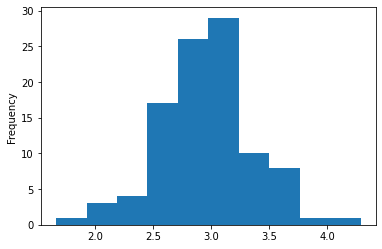

In [6]:
lessons_performance.average_rating.plot.hist()

<AxesSubplot:ylabel='Frequency'>

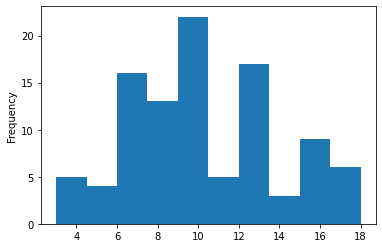

In [7]:
lessons_performance.total_students.plot.hist()

<AxesSubplot:ylabel='Frequency'>

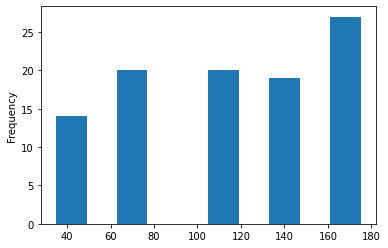

In [8]:
lessons_performance.revenue.plot.hist()

#### Top rated lessons

In [13]:
sorted = lessons_performance.sort_values(by="average_rating", ascending=False)[['teacher_id', 'teacher_name', 'average_rating']]
sorted.head(5)

,teacher_id,teacher_name,average_rating
22,62671b9cbb13db8215b3d73c,Angela Schultz,4.285714
78,62671b9cbb13db8215b3d75a,Andrew Anderson,3.800000
32,62671b9cbb13db8215b3d750,Sharon Reed,3.666667
3,62671b9cbb13db8215b3d716,Christopher Escobar,3.666667
80,62671b9cbb13db8215b3d757,Sarah Bautista,3.625000


#### Top revenue lessons

In [17]:
sorted = lessons_performance.sort_values(by="revenue", ascending=False)[['teacher_id', 'teacher_name', 'revenue']]
sorted.head(5)

,teacher_id,teacher_name,revenue
0,62671b9cbb13db8215b3d6e3,Erin Velazquez,175
69,62671b31bb13db8215b3d5b2,Melanie Todd,175
35,62671b31bb13db8215b3d59c,Erin Guerrero,175
43,62671b9cbb13db8215b3d740,James Butler,175
49,62671b9cbb13db8215b3d6ee,Joann Hall,175


#### Most popular lessons

In [18]:
sorted = lessons_performance.sort_values(by="total_students", ascending=False)[['teacher_id', 'teacher_name', 'total_students']]
sorted.head(5)

,teacher_id,teacher_name,total_students
70,62671b9cbb13db8215b3d708,Derrick Mitchell,18
34,62671b31bb13db8215b3d59c,Erin Guerrero,17
61,62671b31bb13db8215b3d598,Kelsey Thomas,17
79,62671b9cbb13db8215b3d737,Tony Taylor,17
21,62671b9cbb13db8215b3d6b9,Brian Nash,17


### Worst rated lessons

In [20]:
sorted = lessons_performance.sort_values(by="average_rating", ascending=True)[['teacher_id', 'teacher_name', 'average_rating']]
sorted.head(5)

,teacher_id,teacher_name,average_rating
1,62671b31bb13db8215b3d5e3,Danielle Bennett,1.666667
2,62671b31bb13db8215b3d5ce,Tyler Ward,2.000000
43,62671b9cbb13db8215b3d740,James Butler,2.000000
60,62671b31bb13db8215b3d5a6,Terrence White,2.133333
85,62671b9cbb13db8215b3d70a,Andrew Washington,2.333333
